In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import matplotlib as mpl
from scipy.stats import entropy
import climate_indices
from climate_indices import indices


c:\Users\luisg\anaconda3\envs\test_spi\lib\site-packages\climate_indices\utils.py:149: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def reshape_to_2d(
c:\Users\luisg\anaconda3\envs\test_spi\lib\site-packages\climate_indices\utils.py:199: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def reshape_to_divs_years_months(
c:\Users\luisg\anaconda3\envs\test_spi\lib\si

In [3]:
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
scale = 12
distribution = climate_indices.indices.Distribution.gamma
data_start_year = 2001
calibration_year_initial = 2001
calibration_year_final = 2020
periodicity = climate_indices.compute.Periodicity.monthly

In [4]:
ds_spi = {}
folder_metric = r'Data\Datasets\amz\ts'
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
    da_precip_groupby = ds.pr.stack(point=('lat', 'lon')).groupby('point')
    da_spi = xr.apply_ufunc(indices.spi,
                        da_precip_groupby,
                        scale,
                        distribution,
                        data_start_year,
                        calibration_year_initial,
                        calibration_year_final,
                        periodicity)

    da_spi = da_spi.unstack('point')
    ds_spi[datasets_names[i]] = da_spi
    print(datasets_names[i])

CRU
GPCC
CHIRPS
IMERG-V6
TerraClimate
ERA5-Land
JRA55
MERRA2


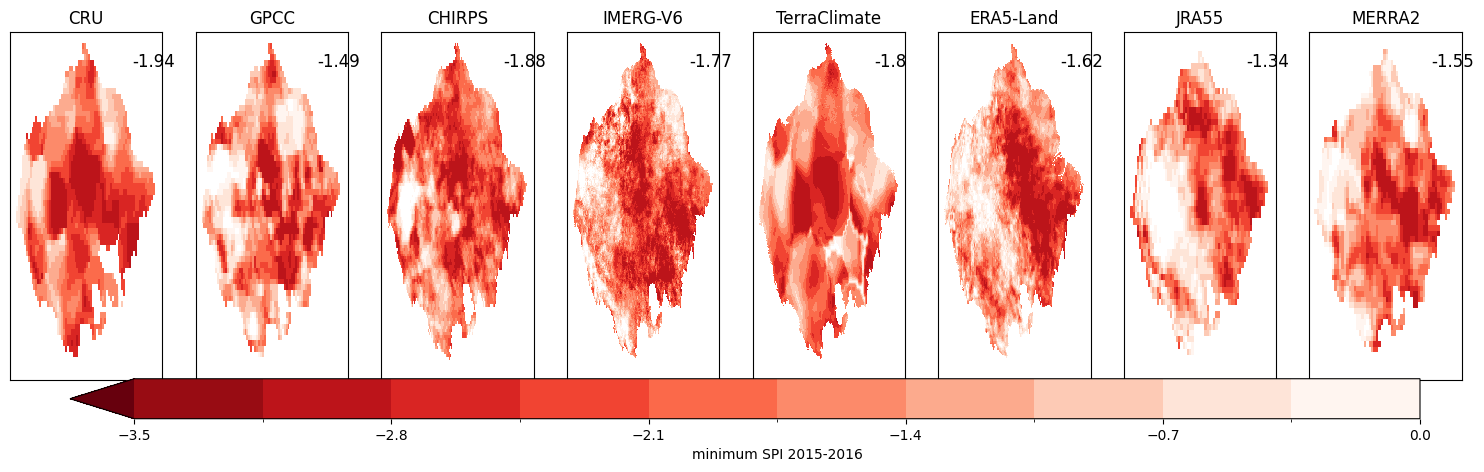

In [9]:
#import cartopy.crs as ccrs
import matplotlib as mpl
#create a dictionary withh all datasets
vmin = -3.5
vmax = 0
levels = 11
#proj = ccrs.Mercator()
extend = [-81, -42, -20, 11]
cmap = mpl.cm.Reds_r
bounds = np.linspace(vmin,vmax, levels)
extend_cmap = 'min'
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend=extend_cmap )
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

# Create a figure and a gridspec layout
fig, axes = plt.subplots(ncols=len(datasets_names), nrows=1, figsize=(15, 4))
#color bar
cax = fig.add_axes([0.05, -0.06, 0.9, 0.1])
fig.colorbar(sm, cax=cax, orientation='horizontal', label='minimum SPI 2015-2016')
# Loop through the datasets and plot them
for i, name in enumerate(datasets_names):
    # Create an axis for the subplot
    ds = ds_spi[name].where(np.isinf(ds_spi[name]) == False).sel(time=slice('2015', '2016')).min(dim='time')
    im = ds.plot(ax=axes[i], cmap=cmap,vmin=vmin, vmax=vmax, add_colorbar=False, levels= levels, extend=extend_cmap )
    axes[i].set_title(name)
    #axes[i].add_geometries(shp_pan.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    #axes[i].set_extent(extend)
    #axes[i].coastlines()
    ##annotate in the top right corner the mean of ds
    axes[i].annotate(str(ds.mean().values.round(2)), xy=(0.80, 0.9), xycoords='axes fraction', fontsize=12)

plt.tight_layout()